In [1]:
#import math
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
#from torchsummary import summary
#from tqdm import tqdm
fp_data = "Au\Dataset\Au_defect_dataset.h5"
fp_metadata = "Au\Metadata\Au_defect_metadata.pkl"
fp_metadata1 = "Au\Metadata\Au_clean_metadata.pkl"

In [2]:
f = h5py.File(fp_data, 'r')
defect_data = np.array(f['defect_data'])
clean_data = np.array(f['clean_data'])#[:,:256,:256]
f.close() # important to close the file for h5 files before ending the script/scope

In [3]:
def normalize(data):
    # Reshape the data into a 2D array
    nsamples, nx, ny = data.shape
    data = data.reshape((nsamples, nx*ny))
    
    # Normalize the data
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    
    return data, scaler

def split_and_transform(data, scaler, split):
    # Normalize the data using the scaler
    data = scaler.transform(data)
    
    # Split the data into training, validation, and testing sets
    N_data = data.shape[0]
    N_train = int(N_data * split[0])
    N_val = int(N_data * split[1])
    N_test = int((N_data *split[2]))
    
    train_data = data[:N_train, :]
    val_data = data[N_train:N_train+N_val, :]
    test_data = data[N_train+N_val:N_train+N_val+N_test, :]
    
    # Transform the data into PyTorch tensors and reshape
    train_data = torch.from_numpy(train_data).to(torch.float32).reshape(-1, 512, 512)[:, None, :, :]
    val_data = torch.from_numpy(val_data).to(torch.float32).reshape(-1, 512, 512)[:, None, :, :]
    test_data =  torch.from_numpy(test_data).to(torch.float32).reshape(-1, 512, 512)[:, None, :, :]
    
    
    return train_data, val_data, test_data

# Normalize the defect data
defect_data, scaler = normalize(defect_data)

# Splitting the data into training, validation, and testing sets
defect_train_split, defect_val_split, defect_test_split = 0.06, 0.02, 0.02

clean_train_split, clean_val_split, clean_test_split = 0.06, 0.02, 0.02

# Split and transform the defect data

defect_train, defect_val, defect_test = split_and_transform(defect_data, scaler, (defect_train_split, defect_val_split, defect_test_split))

# Normalize the clean data
clean_data, scaler = normalize(clean_data)

# Split and transform the clean data
clean_train, clean_val, clean_test = split_and_transform(clean_data, scaler, (clean_train_split, clean_val_split, clean_test_split))




In [4]:
defect_train.shape

torch.Size([46, 1, 512, 512])

In [5]:
def get_xy(defect_data, clean_data):
    N = len(defect_data)
    X = np.concatenate([-1*defect_data, 1*clean_data], axis=0)
    Y = np.zeros((2*N, 2), dtype = 'float32')
    Y[:N, 1] = 1
    Y[N:, 0] = 1
    return X, Y

class DefectCountDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.img = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.img[idx,:,:]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

X_train , Y_train = get_xy(defect_train, clean_train)
X_val, Y_val = get_xy(defect_val, clean_val)
X_test, Y_test = get_xy(defect_test, clean_test)
defect_train_dataset = DefectCountDataset(X_train, Y_train)
train_dataloader = DataLoader(defect_train_dataset, batch_size=128, shuffle=True)


defect_val_dataset = DefectCountDataset(X_val, Y_val)
val_dataloader = DataLoader(defect_val_dataset, batch_size=128, shuffle=True)


defect_test_dataset = DefectCountDataset(X_test, Y_test)
test_dataloader = DataLoader(defect_test_dataset, batch_size=128, shuffle=True)


In [6]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        if len(input.shape) < 4:
            input = input[None,:,:,:]
           
        else:
            input = input
        #input = input.reshape(input.size(0), -1)
        return input.reshape(-1, input.size(1)*input.size(2)*input.size(3))

In [12]:
import torch
import torch.nn as nn

class ClassificationNN(nn.Module):
    def __init__(self, input_channel, num_classes, num_conv_layers, conv_output_channels, kernel_size, stride, padding, 
                 activations,dropout_probs, use_batchnorm, use_maxpool,Maxpool_size, Height, Width):
        super(ClassificationNN, self).__init__()
        
        # Initialize list of layers
        layers = []
        
        # Create convolutional layers
        for i in range(num_conv_layers):
            # Create convolutional layer
            conv = nn.Conv2d(in_channels=input_channel,out_channels=conv_output_channels[i],kernel_size=kernel_size,stride =stride,padding=padding)
            # Initialize weights using Kaiming initialization
            nn.init.kaiming_normal_(conv.weight)
            input_channel = conv_output_channels[i]
            
            # Add convolutional layer to model
            layers.append(conv)
            
            # Add activation function
            layers.append(activations[i])

            # Calulate what the final dimensions will be (w/o Maxpool, see below)
            New_Height = ((Height - kernel_size + 2*padding)//stride + 1)

            New_Width = ((Width - kernel_size + 2*padding)//stride + 1)

            # Add dropout layer if specified
            if dropout_probs[i] > 0:
                dropout_layer = nn.Dropout(p=dropout_probs[i])
                layers.append(dropout_layer)

            # Add batch normalization layer if specified
            if use_batchnorm[i]:
                layers.append(nn.BatchNorm2d(conv_output_channels[i]))
            
            # Add max pooling layer if specified
            if use_maxpool[i]:
                layers.append(nn.MaxPool2d(Maxpool_size))
                # Calulate what the final dimensions will be (if there's a maxpool)
                New_Height = New_Height  // Maxpool_size
                New_Width = New_Width // Maxpool_size

            # Update the final dimensions values
            Height = New_Height
            Width = New_Width
            #print(Width)
                    
        # Flatten layer
        layers.append(Flatten())

        # Add fully connected layer
        layers.append(nn.Linear( conv_output_channels[i] * (New_Height*New_Width), num_classes))
        
        # Add softmax activation function
        layers.append(nn.Softmax(dim=1))
        
        # Create Sequential model
        self.Conv_layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.Conv_layers(x)

# Define model
model = ClassificationNN(input_channel=1, num_classes=2, num_conv_layers=6, conv_output_channels = [16, 24, 30, 32, 32, 32], kernel_size = 5, stride = 1,
                         padding = 1,activations=[nn.ReLU(), nn.ReLU(), nn.ReLU(),nn.Tanh(),nn.Tanh(),nn.Tanh()],dropout_probs = [0.1, 0.2, 0.4, 0.4, 0.2, 0.1], use_batchnorm=[False, False, False, False, False, False], 
                         use_maxpool=[True, False, True, False, False, False], Maxpool_size = 2, Height = 512, Width = 512)
print(model)


ClassificationNN(
  (Conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Conv2d(24, 30, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Dropout(p=0.4, inplace=False)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(30, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (12): Tanh()
    (13): Dropout(p=0.5, inplace=False)
    (14): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (15): Tanh()
    (16): Dropout(p=0.5, inplace=False)
    (17): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (18): Tanh()
    (19): Dropout(p=0.5, inplace=Fal

In [13]:
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=9e-7)

Epoch: 1/15 	Training Loss: 0.227918 	Validation Loss: 0.129435 	lr: 0.0000009000
Epoch: 2/15 	Training Loss: 0.192652 	Validation Loss: 0.082725 	lr: 0.0000009000
Epoch: 3/15 	Training Loss: 0.166889 	Validation Loss: 0.051465 	lr: 0.0000009000
Epoch: 4/15 	Training Loss: 0.127885 	Validation Loss: 0.030543 	lr: 0.0000009000
Epoch: 5/15 	Training Loss: 0.115982 	Validation Loss: 0.016525 	lr: 0.0000009000
Epoch: 6/15 	Training Loss: 0.072792 	Validation Loss: 0.008931 	lr: 0.0000009000
Epoch: 7/15 	Training Loss: 0.075674 	Validation Loss: 0.004646 	lr: 0.0000009000
Epoch: 8/15 	Training Loss: 0.053680 	Validation Loss: 0.002522 	lr: 0.0000009000
Epoch: 9/15 	Training Loss: 0.043934 	Validation Loss: 0.001390 	lr: 0.0000009000
Epoch: 10/15 	Training Loss: 0.040627 	Validation Loss: 0.000897 	lr: 0.0000009000
Epoch: 11/15 	Training Loss: 0.036303 	Validation Loss: 0.000887 	lr: 0.0000000900
Epoch: 12/15 	Training Loss: 0.036460 	Validation Loss: 0.000832 	lr: 0.0000000900
Epoch: 13/15 

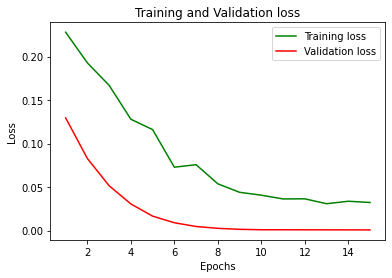

In [14]:
from torch.optim.lr_scheduler import StepLR
# Initialize empty lists to store training and validation losses
train_loss = []
val_loss = []
learning_rates = []
# Set the number of epochs to train the model
n_epochs = 15

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Loop over the number of epochs
for epoch in range(1, n_epochs+1): 
    # Initialize running training and validation losses to 0
    running_loss_train = 0.0
    running_loss_val = 0.0
    
    # Set the model to train mode
    model.train()
    
    # Loop over the training data
    for train_data in train_dataloader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Retrieve images and image labels from the dataloader
        train_images, train_labels = train_data
        # Forward pass: compute predicted outputs by passing inputs to the model
        train_outputs = model(train_images)
        # Calculate the loss
        loss = criterion(train_outputs, train_labels)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update the running training loss
        running_loss_train += loss.item() 
        
    # Set the model to evaluation mode
    model.eval()  
    
    # Loop over the validation data with torch.no_grad() to disable gradient calculations
    with torch.no_grad():
        for val_data in val_dataloader:
            # Retrieve images and image labels from the dataloader
            val_images, val_labels = val_data
            # Forward pass: compute predicted outputs by passing inputs to the model
            val_outputs = model(val_images)
            # Calculate the loss
            loss = criterion(val_outputs, val_labels)
            # Update the running validation loss
            running_loss_val += loss.item()
        
    # Calculate and store the average training loss for the epoch
    running_loss_train /= len(train_dataloader)
    train_loss.append(running_loss_train)
    
    # Calculate and store the average validation loss for the epoch
    running_loss_val /= len(val_dataloader)
    val_loss.append(running_loss_val)

    # retrieve the learning rate at the current epoch
    lr = optimizer.param_groups[0]['lr']
    # store the learning rate in a list
    learning_rates.append(lr)

    # Print the average training and validation losses for the epoch
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tlr: {:.10f}'.format(
        epoch, 
        n_epochs,
        running_loss_train,
        running_loss_val,
        lr
        ))
    

    # Step the learning rate scheduler
    scheduler.step()
    
# Plot the training and validation losses
plt.plot(range(1,n_epochs+1), train_loss, 'g', label='Training loss')
plt.plot(range(1,n_epochs+1), val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# set the model to evaluation mode
model.eval()

# initialize variables to store the total number of correct predictions and total number of predictions
correct = 0
total = 0
N_images = len(defect_test)*2
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data,1)
        _, label = torch.max(labels.data,1)
        total += labels.size(0)
        correct += (predicted == label).sum().item()

print(f'Accuracy of the network on the {N_images} test images: {100 * correct // total} %')


Accuracy of the network on the 30 test images: 100 %


In [15]:
predicted

tensor([0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [16]:
label

tensor([0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])